# Recurrent Color Captioning

This project aims to improve upon the results of previous attempts at captioning colors!

The data is derived from the [Sherwin Williams](https://www.sherwin-williams.com) color catalog but could be improved e.g. by pulling data from [COLOURlovers](http://www.colourlovers.com/)

### Reference points:
- Shane - [New paint colors invented by neural network](http://lewisandquark.tumblr.com/post/160776374467/new-paint-colors-invented-by-neural-network) - generates names _and colors_
- Platt - [`paint_color_names`](https://github.com/devinplatt/paint-color-names) - uses Keras, simple DNN architecture

### Neural Captioning:
- The main reference in this instance is Vinyals et al's [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/pdf/1411.4555.pdf), but _we don't need our 
- https://github.com/karpathy/neuraltalk2
- [`caption_generator`](https://github.com/anuragmishracse/caption_generator) - based off of Vinyals's model, in Keras.
- https://github.com/oarriaga/neural_image_captioning
- [Grounded Compositional Semantics for Finding and Describing Images with Sentences](https://nlp.stanford.edu/~socherr/SocherKarpathyLeManningNg_TACL2013.pdf) - Socher, Karpathy

### Thoughts:
- Shane & Platt both seem to feed colors as RGB values - I think using HSL as a base could be more interesting.
- Platt's code doesn't use an RNN - let's trying running the color names though an LSTM
- this is my first multi-input model, I have no idea what I'm doing

In [368]:
import numpy as np
import os
from colorsys import rgb_to_hsv, hsv_to_rgb

import keras
from keras.layers import Input, Dense, Embedding, LSTM, TimeDistributed, concatenate, Activation
from keras.layers.core import RepeatVector
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import get_file

In [206]:
EMBEDDING_DIM = 100
MAX_LEN = 3 # max length of color name - nothing gets this long though

In [207]:
def process_line(line):
    l = line.strip().split('\t')
    
    _, name, r, g, b = l
    
    hsv = rgb_to_hsv(
        int(r) / 255,
        int(g) / 255,
        int(b) / 255
    )
    
    return name, hsv

In [208]:
text = get_file('sherwin.txt', 'https://raw.githubusercontent.com/devinplatt/paint-color-names/master/sherwin.txt')
lines = [process_line(line) for line in open(text)]

In [222]:
lines[:3]

[('Mulberry Silk',
  (0.04878048780487804, 0.2751677852348994, 0.5843137254901961)),
 ('Chelsea Mauve',
  (0.0752688172043011, 0.16402116402116404, 0.7411764705882353)),
 ('Cabbage Rose',
  (0.04901960784313719, 0.2562814070351758, 0.7803921568627451))]

In [310]:
color_data_in = np.array([line[1] for line in lines])
color_data_in.shape

(1534, 3)

In [210]:
texts = [line[0] for line in lines]

tokenizer = Tokenizer(num_words=10000, )
tokenizer.fit_on_texts(texts)

# turn strings into lists of integer indicies
sequences = tokenizer.texts_to_sequences(texts)

In [211]:
word_index = tokenizer.word_index
token_index = {token: word for word, token in tokenizer.word_index.items()}
print('Found {} unique tokens.'.format(len(word_index)))

Found 1667 unique tokens.


In [212]:
texts[0]

'Mulberry Silk'

In [213]:
data = pad_sequences(sequences, maxlen=MAX_LEN)

In [214]:
indicies = np.arange(data.shape[0])
indicies.shape

(1534,)

now, let's prepare the embeddings layer

In [215]:
import os

embeddings_index = {}
GLOVE_DIR = "/home/ubuntu/.keras/glove"

f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400000 word vectors.


In [216]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
not_found = []
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        not_found.append(word)
    else:
        embedding_matrix[i] = embedding_vector

In [217]:
embeddingLayer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights=[embedding_matrix],
                           input_length=MAX_LEN,
                            trainable=False)

and now the model

In [289]:
vocab_size = len(word_index) + 1

caption_input = Input(shape=(MAX_LEN,), dtype='int32', name='caption_input')
embedding = embeddingLayer(caption_input)

lstm_1 = LSTM(100, return_sequences=True)(embedding)
tdd = TimeDistributed(Dense(EMBEDDING_DIM))(lstm_1)

color_input = Input(shape=(3,), name='color_input')
color_dense = Dense(EMBEDDING_DIM)(color_input)
color_repeated = RepeatVector(MAX_LEN, )(color_dense)

merged_layers = concatenate([tdd, color_repeated])

lstm_2 = LSTM(1000, return_sequences=True)(merged_layers)

output = TimeDistributed(Dense(vocab_size, activation='softmax'),
                         name='output')(lstm_2)

#output = Activation('softmax')(dense)

model = Model(inputs=[caption_input, color_input], outputs=[output])


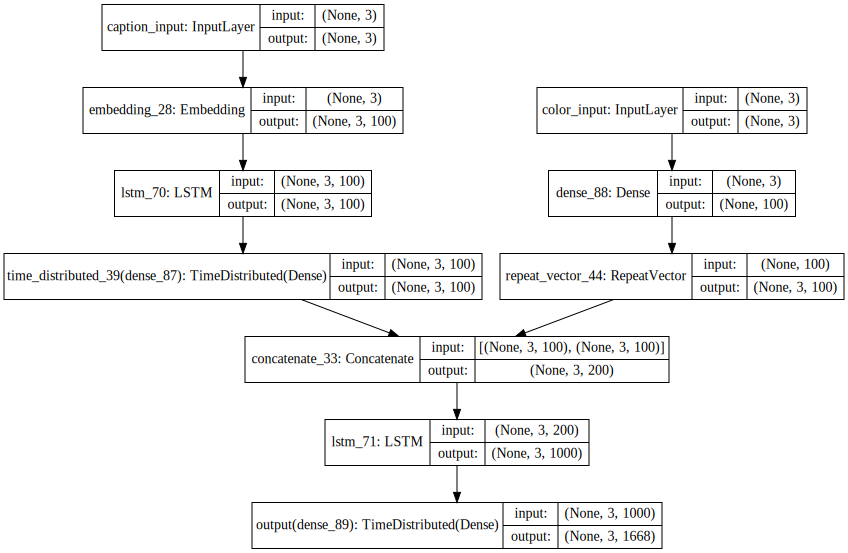

In [290]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [227]:
print(data.shape)
print(np.shape(color_data_in))

(1534, 3)
(1534, 3)


In [229]:
data[0]

array([  0, 183, 184], dtype=int32)

In [293]:
y = np.zeros((data.shape[0], MAX_LEN, vocab_size))

In [294]:
for i, sequence in enumerate(sequences):
    for j, w in enumerate(sequence[:3]):
        y[i, j, w] = 1

In [274]:
np.set_printoptions(threshold=np.inf)

In [303]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [304]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
caption_input (InputLayer)       (None, 3)             0                                            
____________________________________________________________________________________________________
embedding_28 (Embedding)         (None, 3, 100)        166800      caption_input[0][0]              
____________________________________________________________________________________________________
color_input (InputLayer)         (None, 3)             0                                            
____________________________________________________________________________________________________
lstm_70 (LSTM)                   (None, 3, 100)        80400       embedding_28[1][0]               
___________________________________________________________________________________________

In [311]:
from keras.callbacks import ModelCheckpoint

model_names = ('color_weights.{epoch:02d}-{val_loss:.2f}.hdf5')
model_checkpoint = ModelCheckpoint(model_names, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False)

model.fit({'caption_input': data, 'color_input': color_data_in},
          {'output': y},
         epochs=60)

Epoch 1/60
1534/1534 [==============================] - 3s - loss: 4.0612 - acc: 0.0189     
Epoch 2/60
1534/1534 [==============================] - 1s - loss: 3.7023 - acc: 0.0335     
Epoch 3/60
1534/1534 [==============================] - 1s - loss: 3.4870 - acc: 0.0478     
Epoch 4/60
1534/1534 [==============================] - 1s - loss: 3.2566 - acc: 0.0563     
Epoch 5/60
1534/1534 [==============================] - 1s - loss: 3.0281 - acc: 0.0717     
Epoch 6/60
1534/1534 [==============================] - 1s - loss: 2.8316 - acc: 0.0847     
Epoch 7/60
1534/1534 [==============================] - 1s - loss: 2.6652 - acc: 0.0963     
Epoch 8/60
1534/1534 [==============================] - 1s - loss: 2.5154 - acc: 0.1176     
Epoch 9/60
1534/1534 [==============================] - 1s - loss: 2.3793 - acc: 0.1321     
Epoch 10/60
1534/1534 [==============================] - 1s - loss: 2.2469 - acc: 0.1554     
Epoch 11/60
1534/1534 [==============================] - 1s - loss: 2

In [395]:
from IPython.display import Image
def generate_random():
    text = np.zeros((1,MAX_LEN))
    color = np.random.random((1, 3))

    hsv = color[0]
    
    r, g, b = hsv_to_rgb(*hsv)
    
    words = []
    for word in range(2):
        pred = model.predict([text, color])
        w = np.argmax(pred[0, word, :])
        words.append(token_index.get(w))
    
    fname = ' '.join(words)
    print(fname)
#     print(r, g, b)
    image_fname = os.path.join('/home/ubuntu/', fname + '.jpg')
    img = np.zeros([100,100,3],dtype=np.uint8)
    img[::].fill(r)
    for i in range(100):
        for j in range(100):
            img[i][j][0] = r * 255
            img[i][j][1] = g * 255
            img[i][j][2] = b * 255

    imsave(image_fname, img)


    display(Image(image_fname))

marsh green


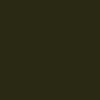

black plum


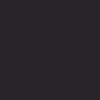

loyal red


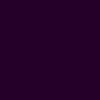

majestic grape


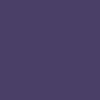

major blue


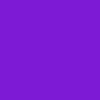

dynamic blue


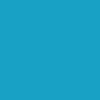

web gray


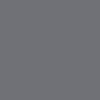

youthful coral


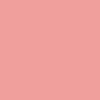

sturdy ̈¦g


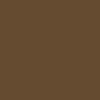

In [396]:
generate_random()
generate_random()
generate_random()
generate_random()
generate_random()
generate_random()
generate_random()
generate_random()
generate_random()

fountain blue


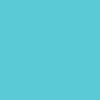

zany pink


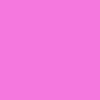

black grape


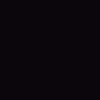

magnetic gray


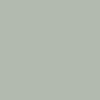

sturdy gold


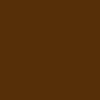

black country


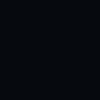

snowfall white


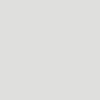

real blue


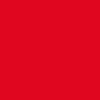

dynamic blue


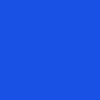

In [408]:
generate_random()
generate_random()
generate_random()
generate_random()
generate_random()
generate_random()
generate_random()
generate_random()
generate_random()

In [410]:
np.random.random((1,3))
[[1, 2, 3]]

[[1, 2, 3]]

In [451]:
from IPython.display import Image
def generate_name(h, s, v):
    text = np.zeros((1,MAX_LEN))
    color = np.array([[ h, s, v]])

    r, g, b = hsv_to_rgb(h, s, v)
    
    words = []
    for word in range(2):
        pred = model.predict([text, color])
        w = np.argmax(pred[0, word, :])
        words.append(token_index.get(w))
    
    fname = ' '.join(words)
    print(fname)
#     print(r, g, b)
    image_fname = os.path.join('/home/ubuntu/', fname + '.jpg')
    img = np.zeros([200,200,3],dtype=np.uint8)
    img[::].fill(r)
    for i in range(200):
        for j in range(200):
            img[i][j][0] = r * 255
            img[i][j][1] = g * 255
            img[i][j][2] = b * 255

    #    img = cv2.putText(img, fname, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    imsave(image_fname, img)

    display(Image(image_fname))

In [452]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual

interact(generate_name, h=(0.0, 1.0, 0.05), s=(0.0, 1.0, 0.05), v=(0.0, 1.0, 0.05))

<function __main__.generate_name>

In [453]:
model.save('final.h5')